In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils
from keras import backend as K

C:\Users\ASUS\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
(x_train0, y_train0),(x_test0, y_test0)=mnist.load_data()
x_train=x_train0.reshape(60000, -1)
x_test=x_test0.reshape(10000, -1)

x_train-=x_train.min()
x_train=x_train/x_train.max()

建立 VAE

In [4]:
enc_1=Dense(100,activation='sigmoid')
enc_mean=Dense(2)
enc_log_var=Dense(2)
dec_2=Dense(100, activation='sigmoid')
dec_1=Dense(784, activation='sigmoid')

In [5]:
x=Input(shape=(784,))
enc_x=enc_1(x)
z_mean=enc_mean(enc_x)
z_log_var=enc_log_var(enc_x)

建立抽樣函數

In [9]:
def sampling(args):
    z_mean, z_log_var=args
    epsilon=K.random_normal(shape=(2,),mean=0.,stddev=1)
    return z_mean+K.exp(z_log_var/2)*epsilon

In [10]:
z=Lambda(sampling,output_shape=(2,))([z_mean,z_log_var])
dec_x = dec_2(z)
x_hat = dec_1(dec_x)

In [11]:
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          78500       input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (

In [12]:
def loss(x,x_recon):  
    recovery_loss=784 * metrics.binary_crossentropy(x,x_recon)
    kl_loss=-0.5*K.sum(1+z_log_var-K.square(z_mean)-K.exp(z_log_var),axis=-1)
    return recovery_loss + kl_loss

In [13]:
VAE.compile(loss=loss,optimizer=Adam())

利用助教給的weight

In [14]:
VAE.load_weights('VAE_handwriting_model_weights.h5')

In [15]:
VAE_Encoder=Model(x,z_mean)
VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [17]:
h_input=Input(shape=(2,))
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))
VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_5 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


encoder 視覺化

In [18]:
indices=np.random.randint(x_test.shape[0],size=1000)
VAE_latents=VAE_Encoder.predict(x_test[indices])

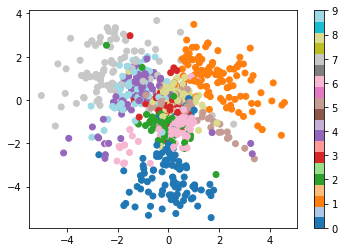

In [19]:
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()
plt.show()

decoder視覺化

In [20]:
def normal(x):
    x -= x.min()
    x /= x.max()
    return x

In [23]:
n=25
digit_size=28
figure=np.zeros((digit_size*n, digit_size*n))
grid_x_vae=np.linspace(-4+0.05,4-0.05,n)
grid_y_vae=np.linspace(4+0.05,4-0.05,n)
VAE_figure=np.zeros((digit_size*n,digit_size*n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample=np.array([[xi, yi]])
        x_decoded=VAE_Decoder.predict(z_sample)
        digit=x_decoded[0].reshape(digit_size,digit_size)
        VAE_figure[(n-i-1)*digit_size: (n-i)*digit_size,
                   j*digit_size: (j+1)*digit_size]=normal(digit)

(-0.5, 699.5, 699.5, -0.5)

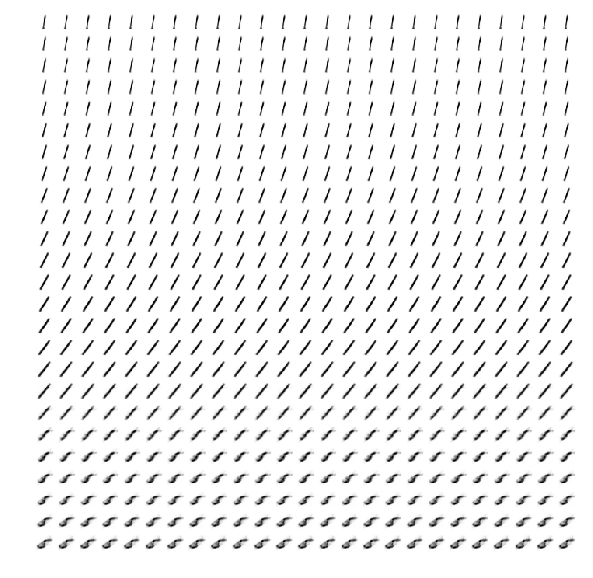

In [26]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')

In [27]:
def inBetween(t):
    data_0=x_train0[idx_1]
    data_1=x_train0[idx_2]
    data_t=(1-t)*x_train0[idx_1]+t*x_train0[idx_2]
    mu_0=VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1=VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t=(1-t)*mu_0 + t*mu_1
    plt.figure(figsize=(10,5))
    ax1=plt.subplot(2,1,2)
    ax1.scatter(mu_0[0],mu_0[1])
    ax1.scatter(mu_1[0],mu_1[1])
    ax1.scatter(mu_t[0],mu_t[1])
    ax2=plt.subplot(2,3,1)
    ax2.imshow(data_0,cmap='Greys')
    ax3=plt.subplot(2,3,2)
    ax3.imshow(data_t,cmap='Greys')
    ax4=plt.subplot(2,3,3)
    ax4.imshow(data_1,cmap='Greys')

In [28]:
idx_1, idx_2=np.random.randint(x_test.shape[0],size=2)
data_0=x_train0[idx_1]
data_1=x_train0[idx_2]

In [29]:
interact(inBetween,t=FloatSlider(value=0.5,min=0,max=1.0,step=0.05,))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.05), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>